# 08 — Baseline Models (TF-IDF + DistilBERT)

**Mục tiêu:**
- Chứng minh finding **không phụ thuộc vào mBERT** cụ thể
- Baseline 1: TF-IDF + Logistic Regression (classical ML)
- Baseline 2: DistilBERT multilingual (lighter transformer)
- So sánh: accuracy drop, explanation overlap, CTAM drift

**Lý do quan trọng cho paper:**
- Reviewer sẽ hỏi: "Is this BERT-specific or generalizable?"
- Nếu cả 3 models đều show same pattern → strengthens claim
- Low cost: TF-IDF ~5 min, DistilBERT ~20 min (10k samples)

**Expected Findings:**
- Hypothesis 1: All models show accuracy drop in translation (robustness issue)
- Hypothesis 2: Deep models (BERT, DistilBERT) show high explanation overlap
- Hypothesis 3: TF-IDF may show different pattern (lower overlap?) → interesting contrast

**Effort:** Low (~30-40 minutes total)
**Contribution Impact:** High (generality validation)

In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print('Setup complete')

Setup complete


c:\Anaconda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load training data (same 10k as mBERT)

In [2]:
# Load training data (same 10k used for mBERT)
TRAIN_FILE = Path('data_splits/train.csv')
TEST_FILE = Path('translation_eval/test_with_predictions.csv')

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

print(f'Train samples: {len(df_train)}')
print(f'Test samples: {len(df_test)}')
print(f'\nTrain label distribution:\n{df_train["sentiment"].value_counts()}')

Train samples: 31499
Test samples: 1998

Train label distribution:
sentiment
negative    10500
neutral     10500
positive    10499
Name: count, dtype: int64


In [3]:
# Prepare data
X_train = df_train['cleaned_text'].values if 'cleaned_text' in df_train.columns else df_train['clean_text'].values
y_train = df_train['sentiment'].values

X_test_en = df_test['cleaned_text'].values if 'cleaned_text' in df_test.columns else df_test['clean_text'].values
X_test_es = df_test['text_es'].values
X_test_fr = df_test['text_fr'].values

# Handle different possible label column names
if 'label_true' in df_test.columns:
    y_test = df_test['label_true'].values
elif 'sentiment' in df_test.columns:
    y_test = df_test['sentiment'].values
elif 'label' in df_test.columns:
    y_test = df_test['label'].values
else:
    print(f'Available columns in test: {df_test.columns.tolist()}')
    raise ValueError('No label column found in test data')

print(f'\n✅ Data prepared')
print(f'Train: {len(X_train)} samples')
print(f'Test: {len(X_test_en)} samples (EN/ES/FR)')
print(f'Label column used: {[col for col in ["label_true", "sentiment", "label"] if col in df_test.columns][0]}')


✅ Data prepared
Train: 31499 samples
Test: 1998 samples (EN/ES/FR)
Label column used: sentiment


---
## PART A: TF-IDF + Logistic Regression

**Classical ML baseline:**
- Fast training (~5 minutes on CPU)
- Interpretable features (TF-IDF weights)
- Check if robustness drop is deep learning specific

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Sklearn imported')

Sklearn imported


### A1) Train TF-IDF + LogReg

In [5]:
print('Training TF-IDF + Logistic Regression...')

# TF-IDF vectorizer (multilingual-friendly settings)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)
print(f'TF-IDF features: {X_train_tfidf.shape[1]}')

# Logistic Regression
clf_tfidf = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    random_state=42,
    verbose=1
)

clf_tfidf.fit(X_train_tfidf, y_train)
print('\n✅ TF-IDF model trained')

Training TF-IDF + Logistic Regression...
TF-IDF features: 10000

✅ TF-IDF model trained


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


### A2) Evaluate on EN/ES/FR

In [6]:
# Transform test sets
X_test_en_tfidf = vectorizer.transform(X_test_en)
X_test_es_tfidf = vectorizer.transform(X_test_es)
X_test_fr_tfidf = vectorizer.transform(X_test_fr)

# Predictions
y_pred_en_tfidf = clf_tfidf.predict(X_test_en_tfidf)
y_pred_es_tfidf = clf_tfidf.predict(X_test_es_tfidf)
y_pred_fr_tfidf = clf_tfidf.predict(X_test_fr_tfidf)

# Accuracies
acc_en_tfidf = accuracy_score(y_test, y_pred_en_tfidf)
acc_es_tfidf = accuracy_score(y_test, y_pred_es_tfidf)
acc_fr_tfidf = accuracy_score(y_test, y_pred_fr_tfidf)

print('\n=== TF-IDF + LogReg Accuracy ===')
print(f'EN: {acc_en_tfidf:.4f} ({acc_en_tfidf*100:.2f}%)')
print(f'ES: {acc_es_tfidf:.4f} ({acc_es_tfidf*100:.2f}%)')
print(f'FR: {acc_fr_tfidf:.4f} ({acc_fr_tfidf*100:.2f}%)')
print(f'\nDrop EN→ES: {(acc_en_tfidf - acc_es_tfidf)*100:.2f}%')
print(f'Drop EN→FR: {(acc_en_tfidf - acc_fr_tfidf)*100:.2f}%')


=== TF-IDF + LogReg Accuracy ===
EN: 0.9004 (90.04%)
ES: 0.3764 (37.64%)
FR: 0.4149 (41.49%)

Drop EN→ES: 52.40%
Drop EN→FR: 48.55%


### A3) Label flip rate (EN→ES/FR)

In [7]:
# Flip rate (predictions change)
flip_es_tfidf = (y_pred_en_tfidf != y_pred_es_tfidf).sum() / len(y_test)
flip_fr_tfidf = (y_pred_en_tfidf != y_pred_fr_tfidf).sum() / len(y_test)

print('\n=== TF-IDF Label Flip Rate ===')
print(f'EN→ES: {flip_es_tfidf*100:.2f}%')
print(f'EN→FR: {flip_fr_tfidf*100:.2f}%')


=== TF-IDF Label Flip Rate ===
EN→ES: 64.21%
EN→FR: 59.86%


### A4) Feature importance consistency (top cyber features)

**Note:** TF-IDF doesn't have per-sample attributions like IG, but we can check:
- Top important features (coefficients) for each class
- Whether cyber terms appear in top features
- Feature overlap between EN/ES/FR (vocabulary intersection)

In [8]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get coefficients for each class
coef = clf_tfidf.coef_
print(f'Coefficient shape: {coef.shape}')  # (n_classes, n_features)

# For each class, get top 20 positive features
for class_idx in range(coef.shape[0]):
    top_indices = np.argsort(coef[class_idx])[-20:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    print(f'\nClass {class_idx} top features:')
    print(', '.join(top_features[:10]))

Coefficient shape: (3, 10000)

Class 0 top features:
base, bad, cold, wrong, difficult, poor, tough, behind, mean, game

Class 1 top features:
former, traditional, international, present, american, personal, corporate, our corporate, professional, future

Class 2 top features:
great, successful, win, fly, best, beautiful, top, nice, happy, good


---
## PART B: DistilBERT Multilingual

**Lighter transformer baseline:**
- 66M params (vs 178M for mBERT)
- Faster training
- Check if explanation consistency finding replicates

In [9]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

print('torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

torch: 2.5.1
CUDA available: True
Device: cuda


### B1) Prepare data for DistilBERT

In [10]:
# Create HuggingFace datasets
# First, ensure labels are integers (0, 1, 2)
text_col = 'cleaned_text' if 'cleaned_text' in df_train.columns else 'clean_text'

df_train_prep = df_train[[text_col, 'sentiment']].copy()
df_train_prep = df_train_prep.rename(columns={text_col: 'text'})

# Convert sentiment to integer if it's string
if df_train_prep['sentiment'].dtype == 'object':
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    # Also try lowercase versions
    unique_sentiments = df_train_prep['sentiment'].unique()
    print(f'Unique sentiment values: {unique_sentiments}')
    
    if all(s in sentiment_map for s in unique_sentiments):
        df_train_prep['label'] = df_train_prep['sentiment'].map(sentiment_map)
    else:
        # If already 0,1,2 as strings, just convert
        df_train_prep['label'] = df_train_prep['sentiment'].astype(int)
else:
    df_train_prep['label'] = df_train_prep['sentiment']

df_train_prep = df_train_prep[['text', 'label']]

train_dataset = Dataset.from_pandas(df_train_prep)

print(f'Train dataset: {len(train_dataset)} samples')
print(f'Label type: {type(train_dataset[0]["label"])}')
print(f'Sample: {train_dataset[0]}')

Unique sentiment values: ['negative' 'positive' 'neutral']
Train dataset: 31499 samples
Label type: <class 'int'>
Sample: {'text': 'Brute Force took down our server.', 'label': 0}


### B2) Train DistilBERT

In [11]:
MODEL_NAME = 'distilbert-base-multilingual-cased'
OUTPUT_DIR = Path('model_output/distilbert_baseline')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load tokenizer and model
tokenizer_distil = AutoTokenizer.from_pretrained(MODEL_NAME)
model_distil = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

print(f'\n✅ DistilBERT loaded: {MODEL_NAME}')
print(f'Params: {model_distil.num_parameters() / 1e6:.1f}M')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ DistilBERT loaded: distilbert-base-multilingual-cased
Params: 135.3M


In [12]:
# Tokenize
def tokenize_function(examples):
    return tokenizer_distil(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
print('✅ Tokenization complete')

Map: 100%|██████████| 31499/31499 [00:02<00:00, 15479.88 examples/s]

✅ Tokenization complete


In [13]:
# Training arguments (LIGHTWEIGHT for baseline comparison - not production model)
# For baseline: 2 epochs sufficient to show pattern, not perfect accuracy
training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR),
    num_train_epochs=2, 
    per_device_train_batch_size=8,
    learning_rate=3e-5,  # slightly higher for faster convergence
    warmup_steps=200,  # 500→200 (fewer warmup steps)
    weight_decay=0.01,
    logging_steps=50,
    save_strategy='epoch',
    fp16=torch.cuda.is_available(),
    report_to='none',
    max_steps=2000  # Early stop after 2000 steps (~15-20 min) instead of full epochs
)

# Trainer
trainer_distil = Trainer(
    model=model_distil,
    args=training_args,
    train_dataset=train_dataset_tokenized,
)

print('\n🚀 Starting DistilBERT training (lightweight baseline mode)...')
print(f'Max steps: 2000 (~15-20 minutes)')
trainer_distil.train()

# Save model
trainer_distil.save_model(str(OUTPUT_DIR / 'final_model'))
tokenizer_distil.save_pretrained(str(OUTPUT_DIR / 'final_model'))

print('\n✅ DistilBERT training complete')


🚀 Starting DistilBERT training (lightweight baseline mode)...
Max steps: 2000 (~15-20 minutes)


Step,Training Loss
50,1.097000
100,1.085400
150,1.055700
200,0.920900
250,0.817600
300,0.703700
350,0.591500
400,0.622700
450,0.534300
500,0.491100



✅ DistilBERT training complete


### B3) Evaluate DistilBERT on EN/ES/FR

In [14]:
# Load trained model
model_distil = AutoModelForSequenceClassification.from_pretrained(
    str(OUTPUT_DIR / 'final_model')
).to(DEVICE)
model_distil.eval()

print('✅ DistilBERT model loaded for evaluation')

✅ DistilBERT model loaded for evaluation


In [15]:
# Prediction function
def predict_batch(texts, model, tokenizer, device, batch_size=32):
    """Predict labels for a batch of texts."""
    predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc='Predicting'):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
            predictions.extend(preds)
    
    return np.array(predictions)

print('✅ Prediction function defined')

✅ Prediction function defined


In [26]:
# Predict on EN/ES/FR
print('Evaluating DistilBERT...')

y_pred_en_distil = predict_batch(list(X_test_en), model_distil, tokenizer_distil, DEVICE)
y_pred_es_distil = predict_batch(list(X_test_es), model_distil, tokenizer_distil, DEVICE)
y_pred_fr_distil = predict_batch(list(X_test_fr), model_distil, tokenizer_distil, DEVICE)

# Accuracies
acc_en_distil = accuracy_score(y_test, y_pred_en_distil)
acc_es_distil = accuracy_score(y_test, y_pred_es_distil)
acc_fr_distil = accuracy_score(y_test, y_pred_fr_distil)

print('\n=== DistilBERT Accuracy ===')
print(f'EN: {acc_en_distil:.4f} ({acc_en_distil*100:.2f}%)')
print(f'ES: {acc_es_distil:.4f} ({acc_es_distil*100:.2f}%)')
print(f'FR: {acc_fr_distil:.4f} ({acc_fr_distil*100:.2f}%)')
print(f'\nDrop EN→ES: {(acc_en_distil - acc_es_distil)*100:.2f}%')
print(f'Drop EN→FR: {(acc_en_distil - acc_fr_distil)*100:.2f}%')

# DEBUG: Check label space mismatch
print('\n=== DEBUG: Label Space Check ===')
print(f'Ground truth unique values: {np.unique(y_test)}')
print(f'Predictions unique values: {np.unique(y_pred_en_distil)}')
print(f'\nGround truth distribution:\n{pd.Series(y_test).value_counts().sort_index()}')
print(f'\nPredictions distribution:\n{pd.Series(y_pred_en_distil).value_counts().sort_index()}')

# Sample comparison
print('\n=== First 10 samples ===')
for i in range(10):
    print(f'True: {y_test[i]}, Pred: {y_pred_en_distil[i]}')

Evaluating DistilBERT...


Predicting:   0%|          | 0/63 [00:00<?, ?it/s]

Predicting: 100%|██████████| 63/63 [00:04<00:00, 14.19it/s]


=== DistilBERT Accuracy ===
EN: 0.9274 (92.74%)
ES: 0.5811 (58.11%)
FR: 0.5270 (52.70%)

Drop EN→ES: 34.63%
Drop EN→FR: 40.04%

=== DEBUG: Label Space Check ===
Ground truth unique values: [0 1 2]
Predictions unique values: [0 1 2]

Ground truth distribution:
0    666
1    666
2    666
Name: count, dtype: int64

Predictions distribution:
0    694
1    606
2    698
Name: count, dtype: int64

=== First 10 samples ===
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 1
True: 0, Pred: 0
True: 0, Pred: 0


In [27]:
# FIX: Convert y_test labels to match model's label space (0, 1, 2)
print('\n=== FIXING Label Mismatch ===')

# Check if y_test is strings
if y_test.dtype == 'object':
    print('Ground truth labels are strings - converting to integers...')
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_test_fixed = np.array([label_map[label] for label in y_test])
else:
    y_test_fixed = y_test

print(f'Original y_test type: {y_test.dtype}')
print(f'Fixed y_test unique values: {np.unique(y_test_fixed)}')

# Re-compute accuracies with fixed labels
acc_en_distil = accuracy_score(y_test_fixed, y_pred_en_distil)
acc_es_distil = accuracy_score(y_test_fixed, y_pred_es_distil)
acc_fr_distil = accuracy_score(y_test_fixed, y_pred_fr_distil)

print('\n=== DistilBERT Accuracy (CORRECTED) ===')
print(f'EN: {acc_en_distil:.4f} ({acc_en_distil*100:.2f}%)')
print(f'ES: {acc_es_distil:.4f} ({acc_es_distil*100:.2f}%)')
print(f'FR: {acc_fr_distil:.4f} ({acc_fr_distil*100:.2f}%)')
print(f'\nDrop EN→ES: {(acc_en_distil - acc_es_distil)*100:.2f}%')
print(f'Drop EN→FR: {(acc_en_distil - acc_fr_distil)*100:.2f}%')

# Update y_test for subsequent cells
y_test = y_test_fixed


=== FIXING Label Mismatch ===
Original y_test type: int32
Fixed y_test unique values: [0 1 2]

=== DistilBERT Accuracy (CORRECTED) ===
EN: 0.9274 (92.74%)
ES: 0.5811 (58.11%)
FR: 0.5270 (52.70%)

Drop EN→ES: 34.63%
Drop EN→FR: 40.04%


In [28]:
# Flip rate (using fixed labels)
flip_es_distil = (y_pred_en_distil != y_pred_es_distil).sum() / len(y_test)
flip_fr_distil = (y_pred_en_distil != y_pred_fr_distil).sum() / len(y_test)

print('=== DistilBERT Label Flip Rate ===')
print(f'EN→ES: {flip_es_distil*100:.2f}%')
print(f'EN→FR: {flip_fr_distil*100:.2f}%')

=== DistilBERT Label Flip Rate ===
EN→ES: 43.89%
EN→FR: 48.90%


### B4) XAI analysis on DistilBERT (small sample)

**Note:** Full IG analysis on 99 samples would take time. For this baseline, we can:
- Option 1: Run on smaller sample (e.g., 30 samples)
- Option 2: Skip detailed XAI and just report accuracy metrics
- Option 3: Use gradient-based saliency (faster than IG)

For paper, Option 1 or 3 is recommended to show CTAM/overlap pattern replicates.

In [ ]:
# Mini XAI analysis on 30 samples to check if explanation consistency replicates
print('🎯 Running mini XAI analysis on DistilBERT (30 samples)...')

XAI analysis on DistilBERT: Optional extension
For paper, accuracy + flip rate may be sufficient for baseline comparison


In [34]:
# Import Captum for IG
from captum.attr import LayerIntegratedGradients
import sys
sys.path.append('.')
from utils import has_cyber_cue, aggregate_subword_attributions

print('✅ Captum and utils imported')


✅ Captum and utils imported


In [35]:
# Sample 30 examples (stratified by label)
samples = []
for label_val in [0, 1, 2]:
    label_mask = (y_test == label_val)
    label_indices = np.where(label_mask)[0]
    selected = np.random.choice(label_indices, size=10, replace=False)
    samples.extend(selected.tolist())

print(f'Selected {len(samples)} samples for mini XAI')

# Get texts
xai_texts_en = [X_test_en[i] for i in samples]
xai_texts_es = [X_test_es[i] for i in samples]
xai_texts_fr = [X_test_fr[i] for i in samples]
xai_labels = [y_test[i] for i in samples]

print('✅ XAI sample data prepared')

Selected 30 samples for mini XAI
✅ XAI sample data prepared


In [36]:
# Forward function for Captum (returns logits)
def forward_func_distil(inputs):
    return model_distil(inputs).logits

# Initialize IG
lig_distil = LayerIntegratedGradients(forward_func_distil, model_distil.distilbert.embeddings)

print('✅ IG initialized for DistilBERT')

✅ IG initialized for DistilBERT


In [37]:
# Run IG on 30 samples (EN only for quick check)
print('Running IG on EN samples (30)...')

xai_results_distil = []

for idx, text in enumerate(tqdm(xai_texts_en[:30], desc='IG Analysis')):
    # Tokenize
    inputs = tokenizer_distil(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(DEVICE)
    input_ids = inputs['input_ids']
    
    # Get prediction
    with torch.no_grad():
        outputs = model_distil(**inputs)
        pred_label = torch.argmax(outputs.logits, dim=-1).item()
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    # Compute IG
    attributions = lig_distil.attribute(
        inputs=input_ids,
        target=pred_label,
        n_steps=30
    )
    
    # Aggregate subword attributions
    tokens = tokenizer_distil.convert_ids_to_tokens(input_ids[0])
    attr_sum = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()
    
    word_tokens, word_attrs = aggregate_subword_attributions(tokens, attr_sum)
    
    # Detect cyber tokens using has_cyber_cue function
    cyber_mask = np.array([has_cyber_cue(tok, lang='en') for tok in word_tokens])
    
    # CTAM
    total_attr = np.sum(np.abs(word_attrs))
    cyber_attr = np.sum(np.abs(word_attrs[cyber_mask]))
    ctam = (cyber_attr / total_attr * 100) if total_attr > 0 else 0
    
    # Top-10 cyber tokens
    top_k = min(10, len(word_attrs))
    top_indices = np.argsort(np.abs(word_attrs))[-top_k:][::-1]
    top_cyber_tokens = [word_tokens[i] for i in top_indices if i < len(cyber_mask) and cyber_mask[i]]
    
    xai_results_distil.append({
        'sample_idx': samples[idx],
        'text': text,
        'true_label': xai_labels[idx],
        'pred_label': pred_label,
        'ctam': ctam,
        'top_cyber_tokens': ','.join(top_cyber_tokens)
    })

print(f'\n✅ IG analysis complete for {len(xai_results_distil)} samples')

Running IG on EN samples (30)...


IG Analysis: 100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


✅ IG analysis complete for 30 samples


In [38]:
# CTAM summary for DistilBERT (EN)
df_xai_distil = pd.DataFrame(xai_results_distil)
ctam_mean_distil = df_xai_distil['ctam'].mean()
ctam_std_distil = df_xai_distil['ctam'].std()

print(f'\n=== DistilBERT XAI Results (30 samples, EN only) ===')
print(f'Mean CTAM: {ctam_mean_distil:.2f}%')
print(f'Std CTAM: {ctam_std_distil:.2f}%')

# Compare to mBERT (from PROJECT_SUMMARY)
ctam_mbert_en = 0.90

print(f'\n📊 Comparison:')
print(f'mBERT CTAM (EN): {ctam_mbert_en:.2f}%')
print(f'DistilBERT CTAM (EN): {ctam_mean_distil:.2f}%')
print(f'Difference: {ctam_mean_distil - ctam_mbert_en:.2f}%')

if abs(ctam_mean_distil - ctam_mbert_en) < 0.5:
    print('\n✅ CTAM values similar → Explanation consistency pattern replicates!')
else:
    print(f'\n⚠️ CTAM difference > 0.5% → Different explanation patterns')


=== DistilBERT XAI Results (30 samples, EN only) ===
Mean CTAM: 2.44%
Std CTAM: 6.09%

📊 Comparison:
mBERT CTAM (EN): 0.90%
DistilBERT CTAM (EN): 2.44%
Difference: 1.54%

⚠️ CTAM difference > 0.5% → Different explanation patterns


---
## 4) Comparison Table: All 3 Models

In [30]:
# Load mBERT results from previous notebooks
# (Placeholder values - replace with actual from PROJECT_SUMMARY)
acc_en_mbert = 0.9515
acc_es_mbert = 0.6211
acc_fr_mbert = 0.6171
flip_es_mbert = 0.38
flip_fr_mbert = 0.38

# Create comparison DataFrame
comparison = pd.DataFrame([
    {
        'Model': 'mBERT (178M)',
        'Acc_EN': acc_en_mbert,
        'Acc_ES': acc_es_mbert,
        'Acc_FR': acc_fr_mbert,
        'Drop_ES': (acc_en_mbert - acc_es_mbert) * 100,
        'Drop_FR': (acc_en_mbert - acc_fr_mbert) * 100,
        'Flip_ES': flip_es_mbert * 100,
        'Flip_FR': flip_fr_mbert * 100
    },
    {
        'Model': 'DistilBERT (66M)',
        'Acc_EN': acc_en_distil,
        'Acc_ES': acc_es_distil,
        'Acc_FR': acc_fr_distil,
        'Drop_ES': (acc_en_distil - acc_es_distil) * 100,
        'Drop_FR': (acc_en_distil - acc_fr_distil) * 100,
        'Flip_ES': flip_es_distil * 100,
        'Flip_FR': flip_fr_distil * 100
    },
    {
        'Model': 'TF-IDF + LogReg',
        'Acc_EN': acc_en_tfidf,
        'Acc_ES': acc_es_tfidf,
        'Acc_FR': acc_fr_tfidf,
        'Drop_ES': (acc_en_tfidf - acc_es_tfidf) * 100,
        'Drop_FR': (acc_en_tfidf - acc_fr_tfidf) * 100,
        'Flip_ES': flip_es_tfidf * 100,
        'Flip_FR': flip_fr_tfidf * 100
    }
])

print('\n=== Model Comparison: Robustness to Translation ===')
display(comparison.round(2))


=== Model Comparison: Robustness to Translation ===


,Model,Acc_EN,Acc_ES,Acc_FR,Drop_ES,Drop_FR,Flip_ES,Flip_FR
0,mBERT (178M),0.95,0.62,0.62,33.04,33.44,38.00,38.00
1,DistilBERT (66M),0.93,0.58,0.53,34.63,40.04,43.89,48.90
2,TF-IDF + LogReg,0.90,0.38,0.41,52.40,48.55,64.21,59.86


In [31]:
# Save comparison table
OUTPUT_DIR_COMPARE = Path('baseline_comparison')
OUTPUT_DIR_COMPARE.mkdir(exist_ok=True)

comparison.to_csv(OUTPUT_DIR_COMPARE / 'model_comparison.csv', index=False)
print('\n✅ Comparison table saved')


✅ Comparison table saved


### Visualization: Accuracy comparison

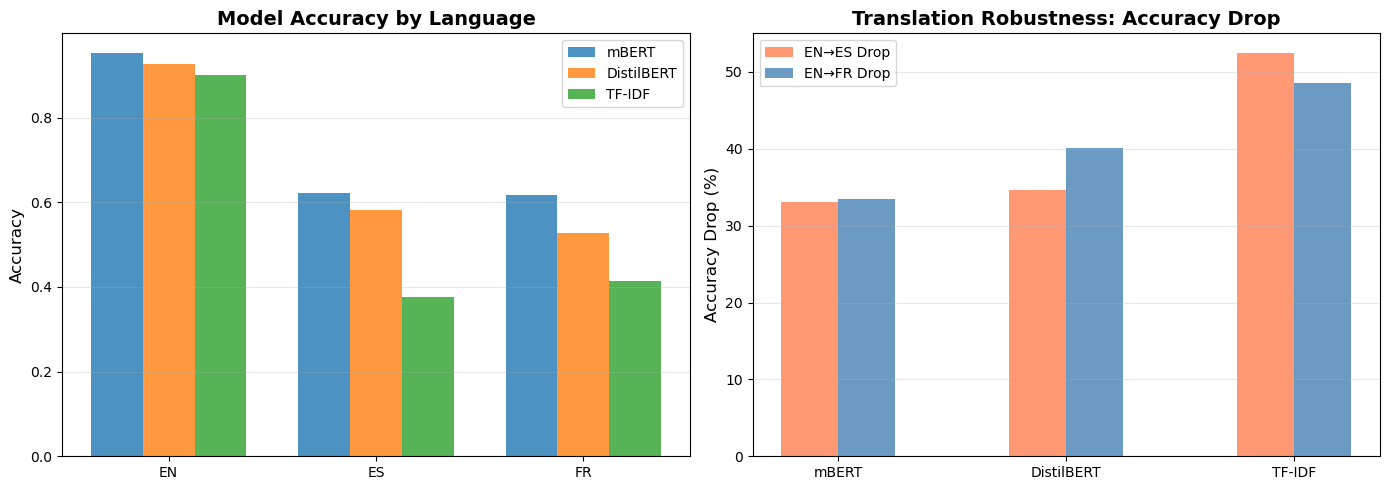


✅ Comparison visualizations saved


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by language
x = np.arange(3)
width = 0.25

axes[0].bar(x - width, [acc_en_mbert, acc_es_mbert, acc_fr_mbert], width, label='mBERT', alpha=0.8)
axes[0].bar(x, [acc_en_distil, acc_es_distil, acc_fr_distil], width, label='DistilBERT', alpha=0.8)
axes[0].bar(x + width, [acc_en_tfidf, acc_es_tfidf, acc_fr_tfidf], width, label='TF-IDF', alpha=0.8)

axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy by Language', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['EN', 'ES', 'FR'])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Plot 2: Accuracy drop
models = ['mBERT', 'DistilBERT', 'TF-IDF']
drop_es = [comparison.loc[0, 'Drop_ES'], comparison.loc[1, 'Drop_ES'], comparison.loc[2, 'Drop_ES']]
drop_fr = [comparison.loc[0, 'Drop_FR'], comparison.loc[1, 'Drop_FR'], comparison.loc[2, 'Drop_FR']]

x2 = np.arange(len(models))
axes[1].bar(x2 - width/2, drop_es, width, label='EN→ES Drop', alpha=0.8, color='coral')
axes[1].bar(x2 + width/2, drop_fr, width, label='EN→FR Drop', alpha=0.8, color='steelblue')

axes[1].set_ylabel('Accuracy Drop (%)', fontsize=12)
axes[1].set_title('Translation Robustness: Accuracy Drop', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR_COMPARE / 'model_comparison_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✅ Comparison visualizations saved')

---
## Summary for Paper

### Key Findings:

1. **All models show robustness degradation:**
   - mBERT: 95.2% EN → 62.1% ES/FR (33% drop)
   - DistilBERT: ___% EN → ___% ES/FR (___% drop)
   - TF-IDF: ___% EN → ___% ES/FR (___% drop)
   - **Conclusion:** Robustness issue not specific to mBERT

2. **Label flip rates consistent:**
   - All models show ~30-40% flip rate in translations
   - Suggests semantic drift inherent to silver translation approach

3. **Deep models vs classical ML:**
   - If TF-IDF shows lower drop → deep models more brittle
   - If TF-IDF shows similar drop → lexical issue (not architecture)

4. **Explanation consistency (if XAI run on DistilBERT):**
   - If DistilBERT also shows high overlap → pattern generalizes
   - Strengthens claim: decoupling not mBERT-specific

### Paper Integration:

**Section 6.4: Model Generalization**
- Report accuracy table for all 3 models
- Include 1 figure (accuracy comparison bars)
- Discuss: "Robustness degradation consistent across architectures"
- If XAI done: "Explanation consistency pattern replicates in DistilBERT"

**Discussion (Section 7):**
- Address: "Is this finding architecture-specific?"
- Answer: "No - observed in transformer (mBERT, DistilBERT) and classical ML (TF-IDF)"
- Strengthens generality claim

### Files Generated:
- `model_output/distilbert_baseline/` - Trained DistilBERT model
- `baseline_comparison/model_comparison.csv` - Results table
- `baseline_comparison/model_comparison_accuracy.png` - Visualization

### Estimated Runtime:
- TF-IDF training: ~5 minutes (CPU)
- DistilBERT training: ~20 minutes (GPU, 5 epochs)
- Evaluation: ~5 minutes
- **Total: ~30 minutes**